# Pairs trading examples#

From Wikipedia:

>The pairs trade or pair trading is a market neutral trading strategy enabling traders to profit from virtually any market conditions: uptrend, downtrend, or sideways movement. This strategy is categorized as a statistical arbitrage and convergence trading strategy.[1] The pair trading was pioneered by Gerry Bamberger and later led by Nunzio Tartaglia’s quantitative group at Morgan Stanley in the 1980s

You can find tons of information on pairs trading by googling for it, so I will continue straight on with building and backtesting a couple of spreads from the energy sector.

In [18]:
%pylab inline
#%qtconsole

Populating the interactive namespace from numpy and matplotlib


In [19]:
import tradingWithPython as twp
from tradingWithPython.lib import yahooFinance as yf
import pandas as pd

twp.extra.setNotebookStyle()

## Get list of XLE components#
Here is another good example of getting a .csv file from the web and parsing it with just a couple lines of code

In [20]:
import urllib.request, urllib.parse, urllib.error
# download file 
urllib.request.urlretrieve('http://www.sectorspdr.com/sectorspdr/IDCO.Client.Spdrs.Holdings/Export/ExportCsv?symbol=xle',
                           'xle.csv') # get buffer object
# parse file
xleComponents = pd.read_csv('xle.csv',sep=',', skiprows=1) #create DataFrame from buffer, use 'tab' as separator
xleComponents # show data in output 能源指数

,Symbol,Company Name,Index Weight,Last,Change,%Change,Volume,52 Week Range,Unnamed: 8
0,XOM,Exxon Mobil Corp,16.12%,84.86,-0.65,-0.76%,12.79 M,73.55 - 95.55,NaN
1,CVX,Chevron Corp,14.63%,111.82,-1.97,-1.73%,8.24 M,79.85 - 119.00,NaN
2,SLB,Schlumberger Ltd,8.24%,83.61,-0.89,-1.05%,5.55 M,66.10 - 87.84,NaN
3,EOG,EOG Resources,4.83%,101.20,-1.70,-1.65%,2.98 M,62.53 - 109.37,NaN
4,PXD,Pioneer Natural Resources,4.67%,178.80,-2.66,-1.47%,1.39 M,105.22 - 195.00,NaN
...,...,...,...,...,...,...,...,...,...
31,HP,Helmerich & Payne Inc,0.52%,70.45,-2.23,-3.07%,2.49 M,44.30 - 85.78,NaN
32,CHK,Chesapeake Energy Corp,0.44%,6.46,-0.46,-6.65%,56.79 M,1.50 - 8.20,NaN
33,MUR,Murphy Oil Corp,0.42%,28.41,-1.57,-5.24%,5.88 M,15.23 - 37.48,NaN
34,SWN,Southwestern Energy Co,0.39%,9.13,-0.29,-3.08%,19.34 M,5.30 - 15.59,NaN


## Get the price data##
Getting data from yahoo is something that you are already familiar with...

In [21]:
symbols = xleComponents['Symbol'].tolist() # convert Series to a list 
symbols.append('XLE') # add etf itself

hData = yf.HistData()
hData.startDate = (2009,1,1) # start from 2009
hData.downloadData(symbols)

 [*********************100%***********************]  37 of 37 complete

## Visualise dataset##
Here we'll take a look at prices and correlations between them.

Last dataset date: 2016-02-01 00:00:00


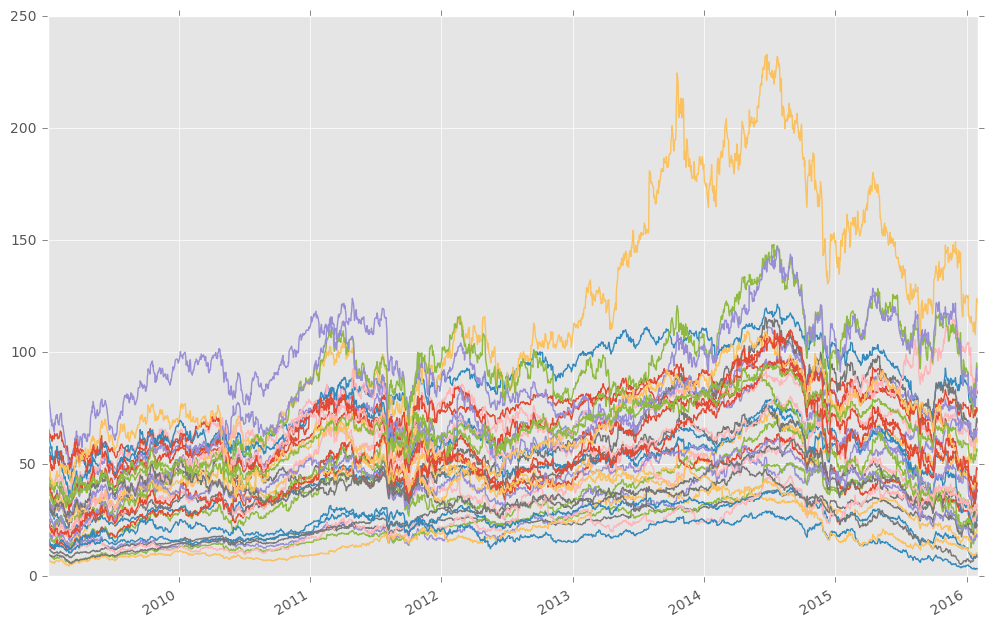

In [22]:
C = hData.getDataFrame('close')[:-250] # exclude last 250 days as out-of-sample data
C = C.dropna(axis=1) # remove symbols containing incomplete data
C.plot(legend=False) # plot prices matrix
print('Last dataset date:' , C.index[-1]) 

Now we can take a look at the correlations within the dataset...

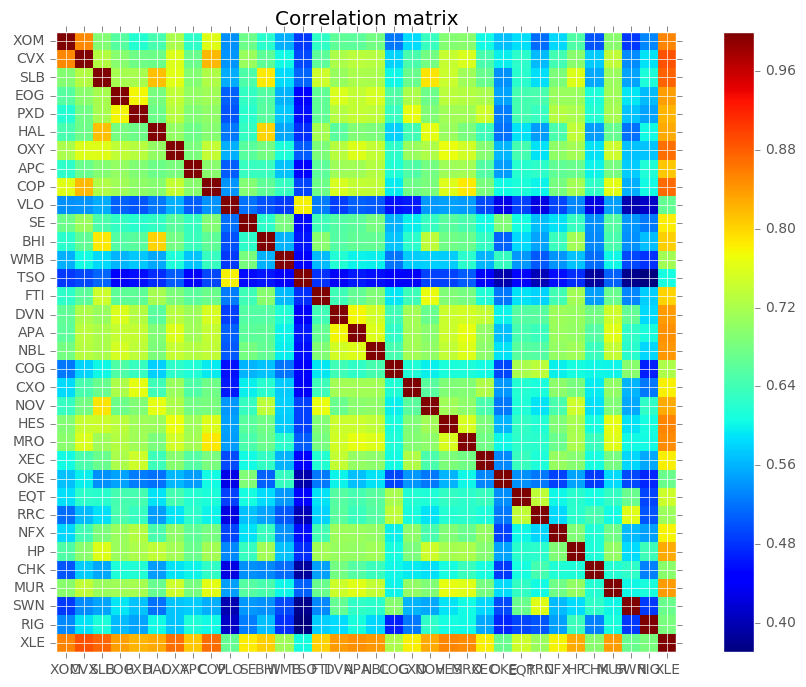

In [23]:
cMat=twp.plotCorrelationMatrix(C) # plot correlation matrix. (Note: the absolute values are plotted)

Most assets are well corelated, only with some exceptions. If you'd like to take a closer look at the actual values, the easiest way is to export this data to excel.

In [24]:
cMat.to_excel('correlation_matrix.xls') #export to excel, take a closer look at the numbers

Now we'll take a look at correlation of CVX to other symbols, to do this, just select the CVX column from the correlation matrix:

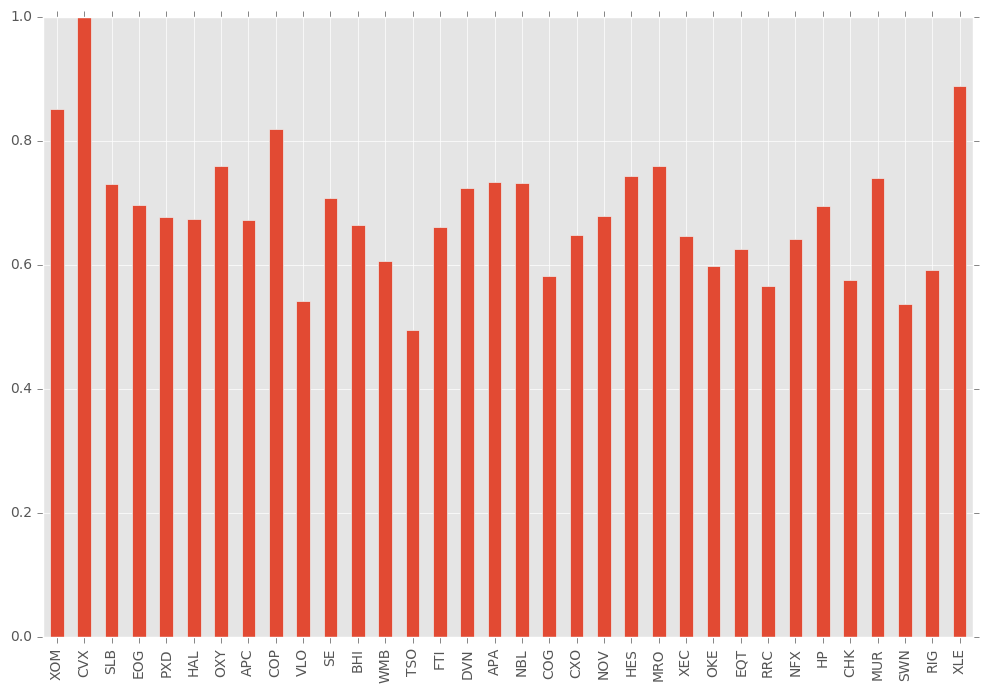

In [25]:
cMat['CVX'].plot(kind='bar') # plot correlation of CVX to other symbols

# Build spread and visualise data#

First I will create a function that builds a spread based on a price matrix and two symbols (which must be in the dataset of course). This function will be reused later on. I will use COP as a pair to CVX due to their high correlation. The spread I'm building here is a market-neutral spread. To acheive it I use the `estimateBeta` function from the twp toolbox. 

capital CVX: 100.00$ capital XOM: -132.90$


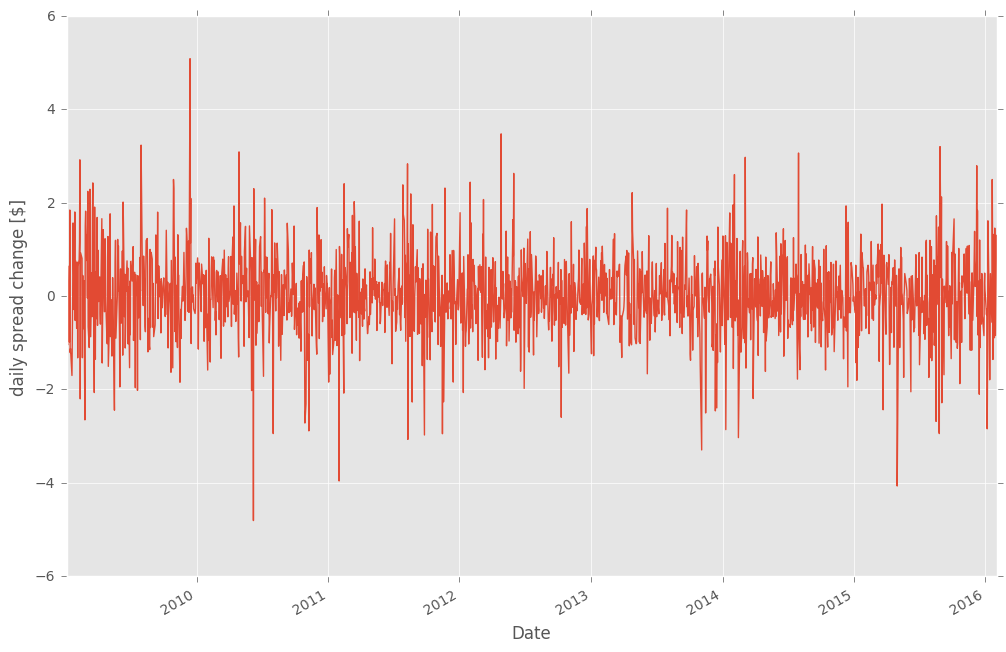

In [26]:
def buildSpread(priceMat, symbolX, symbolY):
    """ 
    create a synthetic spread return from prices matrix 
    symbolX is 100$ long, symbolY is short, beta adjusted
    
    Returns: daily spread change in $

    """
    
    beta = twp.estimateBeta(C[symbolY],C[symbolX])

    capitalX = 100 # 100$ bet on x, long
    capitalY = -100/beta # short position, adjusted for beta to achieve market-neutral spread
    print('capital %s: %.2f$ capital %s: %.2f$' %(symbolX,capitalX,symbolY,capitalY))
    
    ret = priceMat[[symbolX,symbolY]].pct_change() #individual returns in %
    
    ret_pair = ret[symbolX]*capitalX+ret[symbolY]*capitalY
    
    return ret_pair.dropna()
    
R = buildSpread(C,'CVX','XOM') 
R.plot()
xlabel('Date')
ylabel('daily spread change [$]')


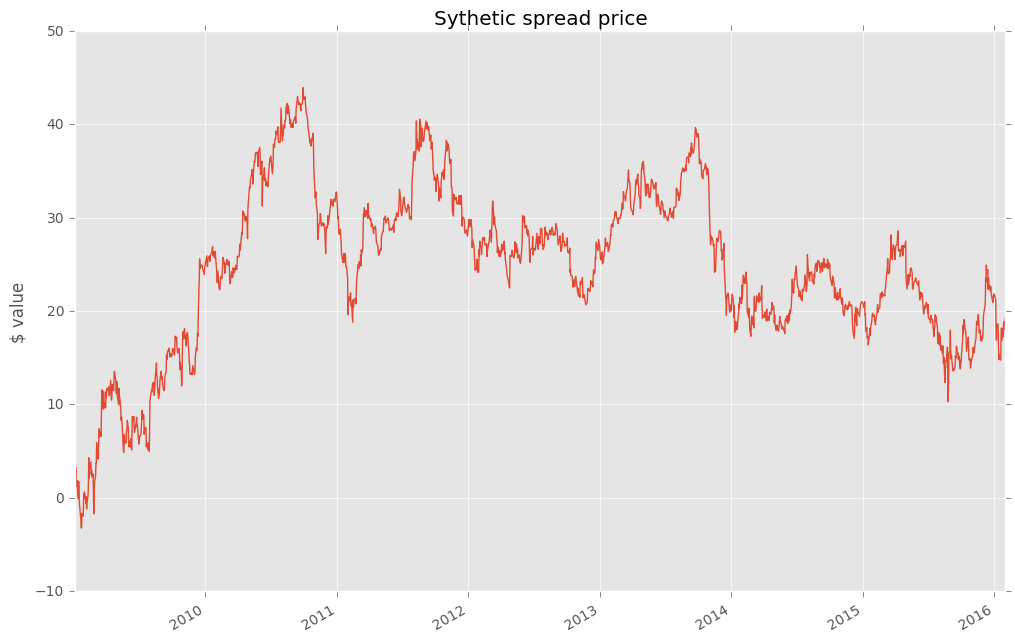

In [27]:
# plot cumulative spread, assuming daily rebalancing to avoid compounding effects. 
R.cumsum().plot()
title('Sythetic spread price')
ylabel('$ value')


Compare daily return distribution to a normal distribution. Example code for plotting comes from [here](http://matplotlib.org/users/screenshots.html#histograms)

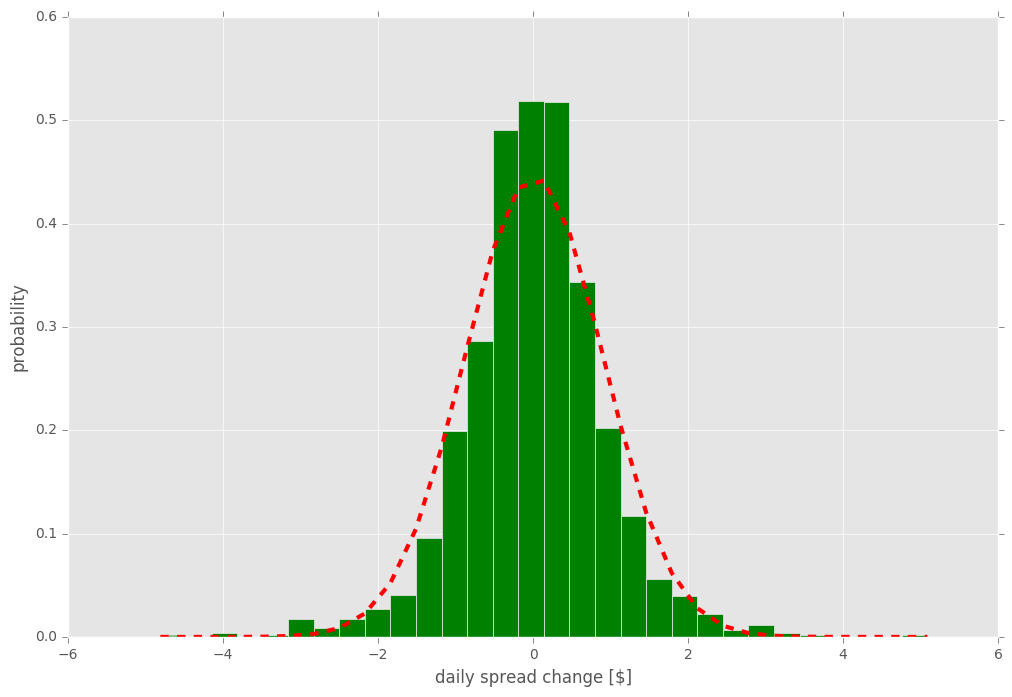

In [28]:
n, bins ,patches = hist(R,30,normed=1,facecolor='green') # plot returns histogram with 50 bins
y = normpdf(bins,R.mean(),R.std())
plot(bins,y,'r--',linewidth=3)
xlabel('daily spread change [$]')
ylabel('probability')
grid(True)


The returns are not really normally distributed, the tails are fatter than one would expect. This is something to keep in mind while doing risk analysis. A fat-tail event could trigger a margin call if you over-leverage.

## Create a trading strategy##
Spreads often show mean-reverting behavior. We will try to exploit this by taking an opposite position after a relatively big daily return.

First we'll create some indicators:

C:\Users\User\Anaconda2\envs\py35\lib\site-packages\ipykernel\__main__.py:4: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(center=False,window=10).std()
C:\Users\User\Anaconda2\envs\py35\lib\site-packages\ipykernel\__main__.py:6: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(center=False,window=10).mean()


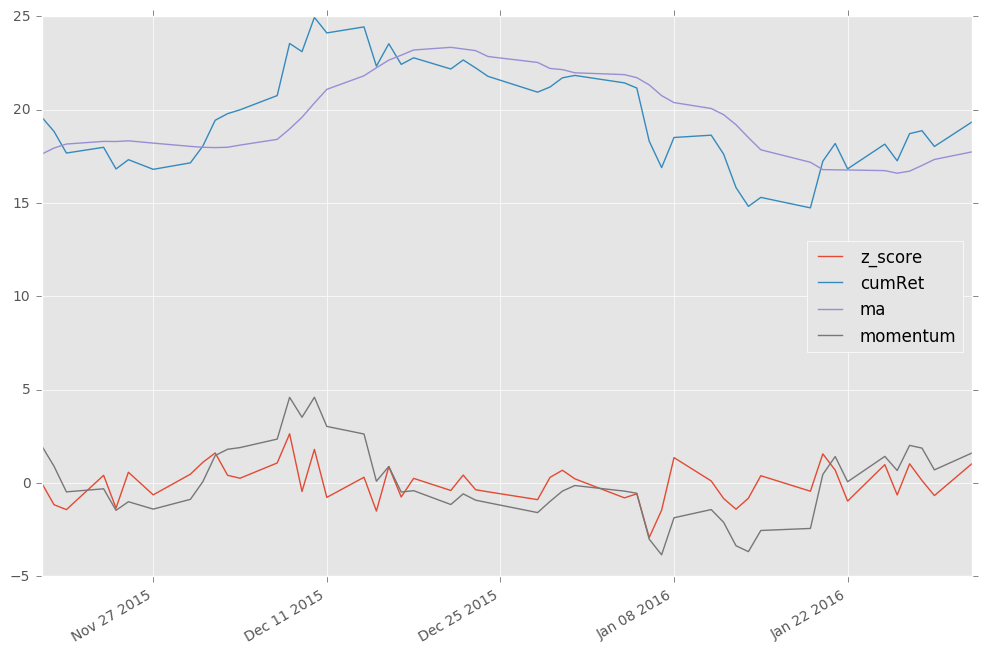

In [30]:
indicators = pd.DataFrame(index = R.index) #prepare indicators DataFrame

window = 10
indicators['z_score'] = R/pd.rolling_std(R,window) # current day return z-score
indicators['cumRet'] = R.cumsum() # total sum of returns, which is a sythetic price
indicators['ma'] = pd.rolling_mean(indicators['cumRet'],window) #moving average of synthetic price
indicators['momentum'] = indicators['cumRet']-indicators['ma'] # difference between synth. 
                                                                #price and ma, gives indication of momentum strength

indicators[-50:].plot()


We will now take a look at the data by visualising next day return as a function of two parameters, in this case *z-score* and *momentum*. A very cool way to do that is to use a scatter plot, where each point size gives an indication of return magnitude and the color shows if it is negative or positive. Based on our mean-reversion expectation there should be more red for positive z-values and more green for negative z-values. 

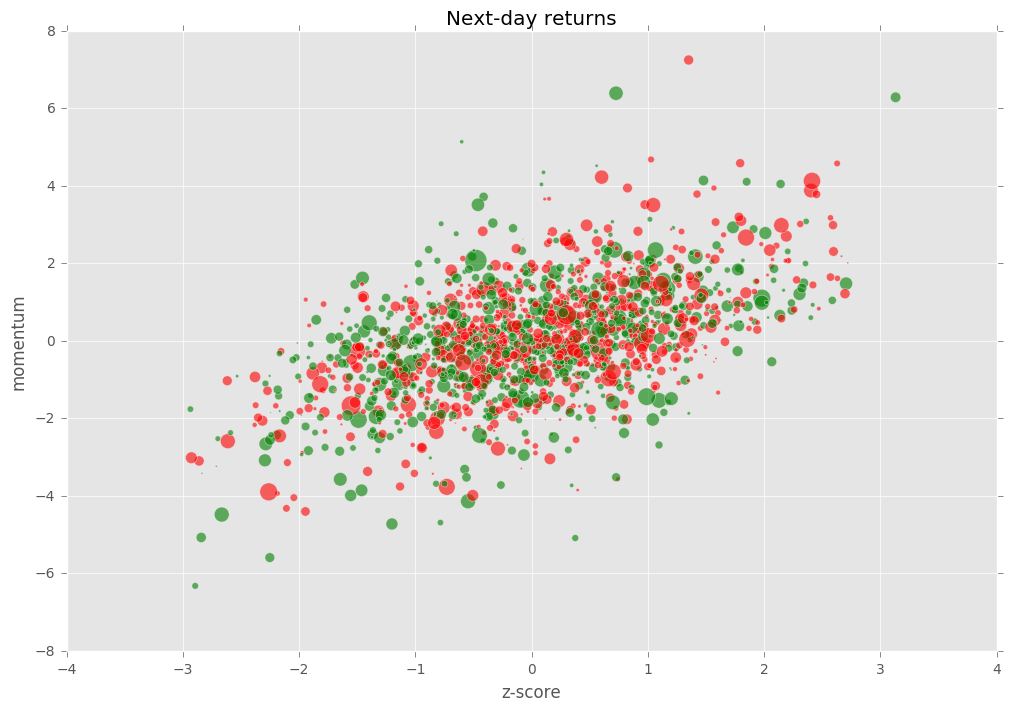

In [31]:
#---create a scatter plot of next day retruns

data = indicators.copy() # create a copy of indicators dataframe in data, which will be used for scatterplot
data['R'] = R # current return
data['R_next'] = R.shift(-1) # next day return, used for circle size, color will be used to show sign

data = data.dropna()

color = pd.Series(index=data.index, data='white')
color[data['R_next']>0] = 'green' # positives are green
color[data['R_next']<0] = 'red' # negatives are red

scatter(data['z_score'],data['momentum'], s=np.abs(50*data['R_next']),c=color.tolist(),alpha=0.6) # note the 'abs' function, as circle diameter must be positive
grid(True)
xlabel('z-score')
ylabel('momentum')
title('Next-day returns')

To be honest, It is very difficult to find structure in this chart, which gives an idea how difficult it is to predict next days returns based on our indicators. 
Nevertheless, let's proceed anyway and build a strategy with these rules:

* If momentum is up and z-score is high, go short, close position next day.
* If momentum is down and z-score is low, go long, close position next day.

To make this strategy easy to (re)use, I will write is as a class. Strategy optimisation is built into the class as `.optimize()` function:

In [ ]:
class StrategyMR1(object):
    """ Mean-reverting strategy 01"""
    def __init__(self,ret,window=50):
        """
        Parameters:
        ------------
        ret: daily return, may be in % or $
        window: window length for z-score
        """
        self.ret = ret  # day returns
        self.price = ret.cumsum() # synthetic price
        self.window = window # window length
        
        #----indicators
        self.z_score = self.ret/pd.rolling_std(self.ret,window) #  current day z-score
        self.aboveAverage = self.price > pd.rolling_mean(self.price,25) # is the price above average? T/F, window size fixed
    
    def backtest(self, z_enter=2.):
        """ backtest with entering on a given z_score """
        pos = pd.Series(index = self.price.index, data=0) # position vector
        
        # simple - one parameter entry
        #pos[(self.z_score > z_enter)] = -1 # short position
        #pos[(self.z_score < -z_enter)] = 1 # long position
        
        pos[self.aboveAverage & (self.z_score > z_enter)] = -1 # short position
        pos[~self.aboveAverage & (self.z_score < -z_enter)] = 1 # long position
        
        pos = pos.shift(1) # todays position has effect on tomorrows return. Shift 1 day into future.
        pnl = self.ret*pos # daily pnl 
        return pnl
        
  
    def optimize(self, plotOn = False):
        """ optimize and optionally plot pnl """
        
        z_enter = np.arange(0.5,3,0.1) # backtest for z 0.5 to 3, steps of 0.1
        sharpe = pd.Series(index = z_enter, data=np.nan)
        
        for z in z_enter:
            pnl = self.backtest(z_enter=z)
            sharpe[z] = twp.sharpe(pnl) 
            if plotOn: pnl.cumsum().plot()
        
        return sharpe
  
#---------------Test strategy -------------------    
R = buildSpread(C,'CVX','COP') 
s = StrategyMR1(R, window=20)
sharpe = s.optimize(plotOn = True)
figure()
sharpe.plot()
xlabel('z-entry')

Well, this strategy does not look like a success. Even after scanning over the parameters nothing pops up that would be tradeable. 
Now let's try to apply same strategy to a single stock instead of a spread:

In [ ]:
s = StrategyMR1(C['XOM'].pct_change(), window=20)
sharpe = s.optimize(plotOn = True)
optimalZ = sharpe.idxmax()
print('Optimal entry: ', optimalZ)

Still not OK, but there seems to be a 'better' period towards the end of 2015. Let's see what would happen out-of sample

In [ ]:
C_full = hData.getDataFrame('close')# include full data now
s = StrategyMR1(C_full['XOM'].pct_change(), window=20)

pnl = s.backtest(z_enter=optimalZ)
pnl.cumsum().plot()

Also out-of-same the strategy is unpredictable ...

## Conclusion
Unfortunately, non-performing strategies are a fact of life. A trader has to try out multiple options before finding something that works. This is often tedious work, nobody said that getting success in trading would be easy...
A big advantage of of quantitative traders is that they have the ability to analyze and backtest the strategy before going into live trading, avoiding costly 'market lessons'.

## Search for a tradeable spread##
We will now do a scan of all possible XLE-??? pairs to see if there are any better trading opportunities for this strategy. The results are for you to judge. 

## Excercize##
Choose a spread with the most promising results and test it out-of-sample
